# Plot Attributes with respect to AvgFuelConsumption_per100km

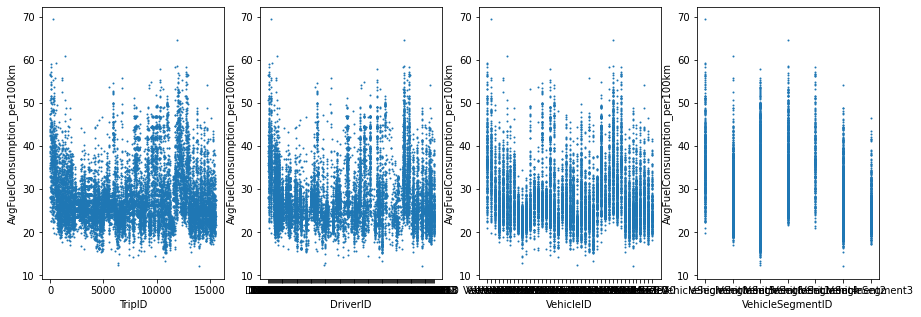

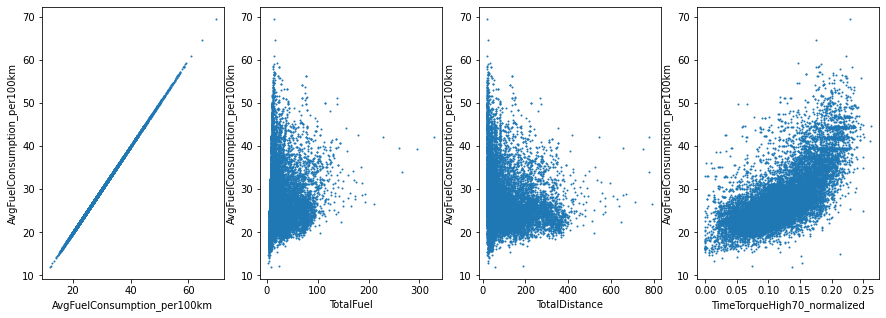

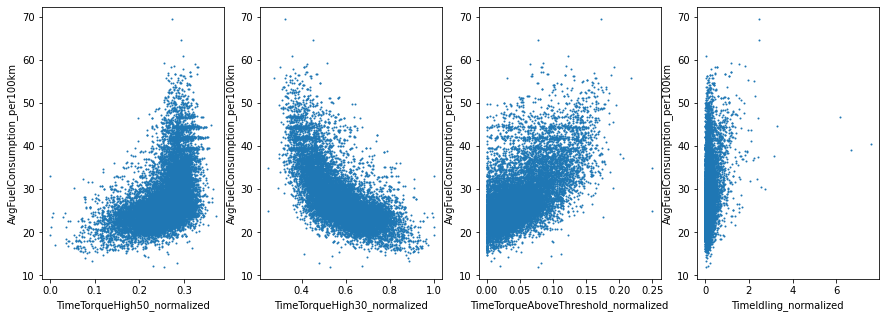

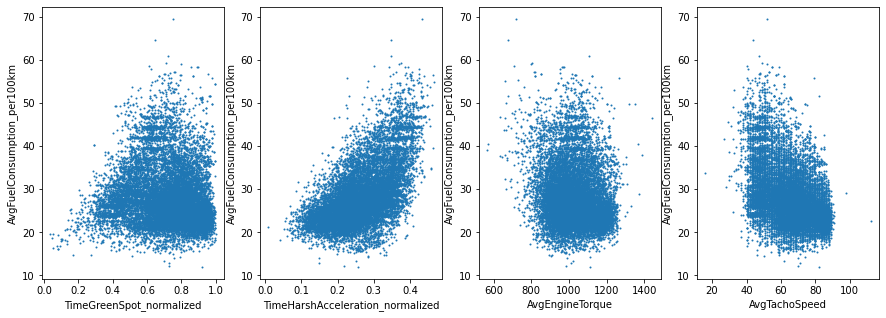

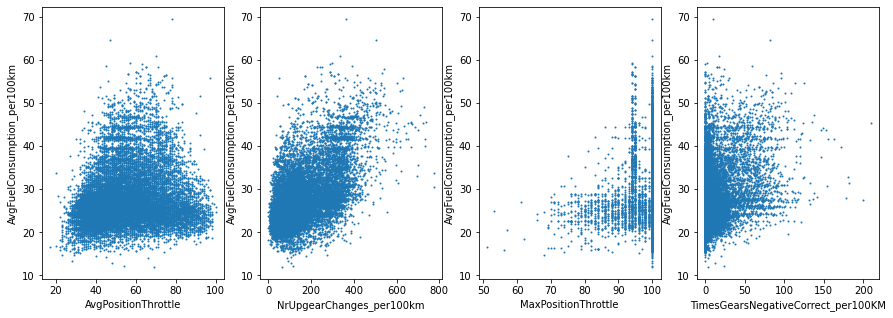

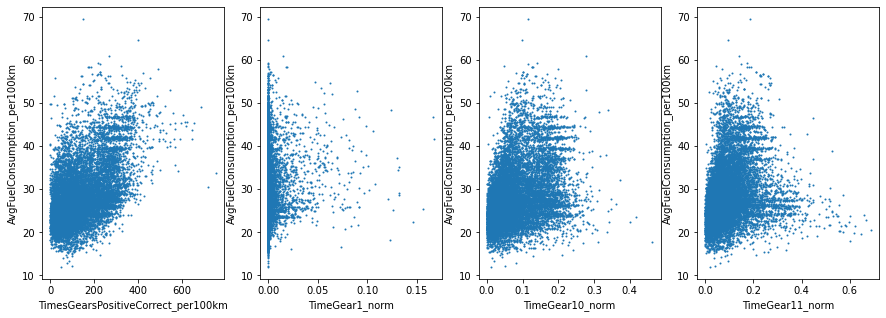

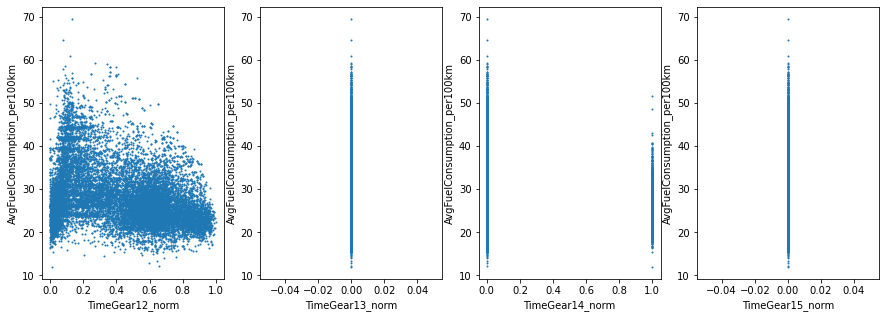

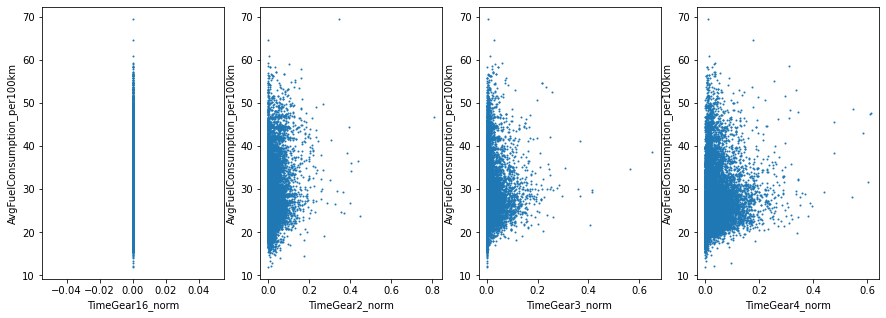

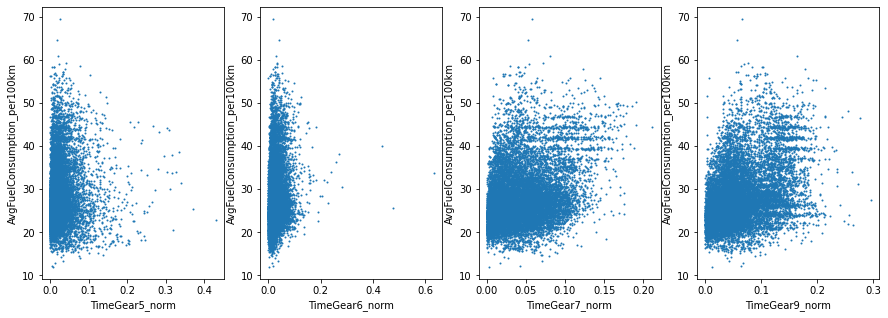

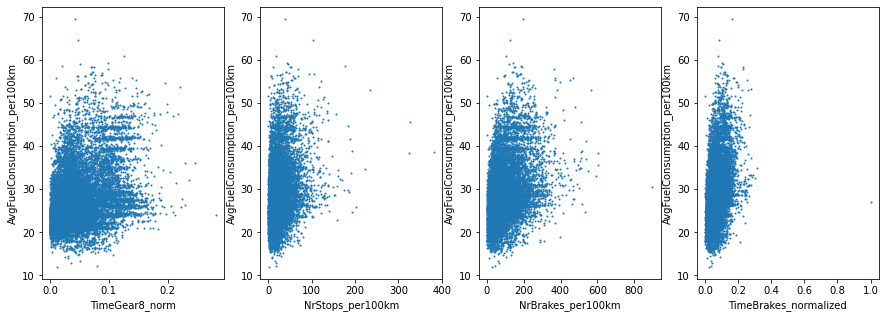

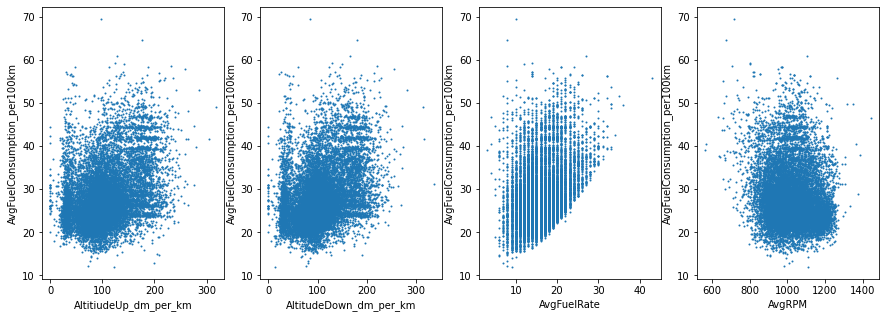

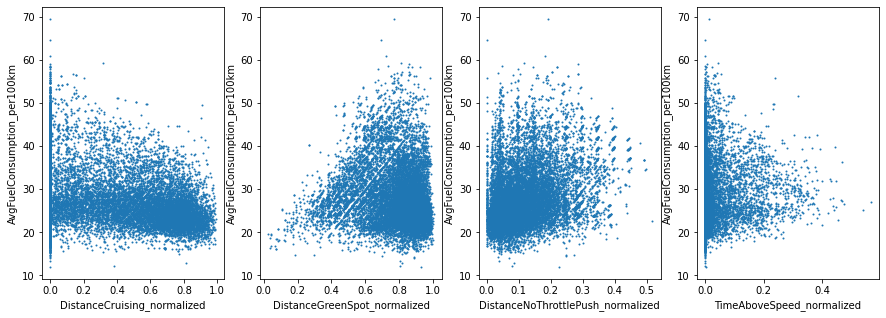

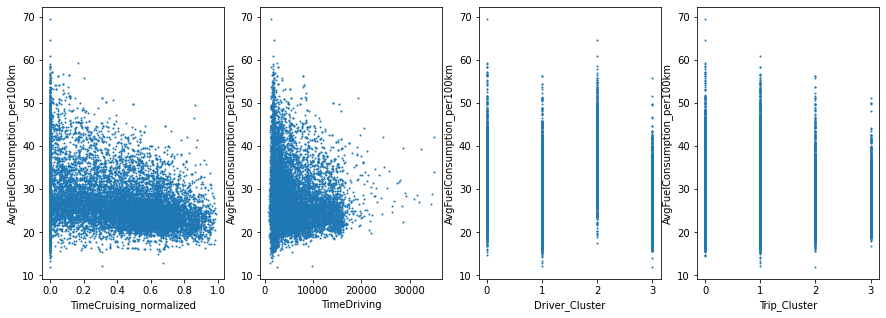

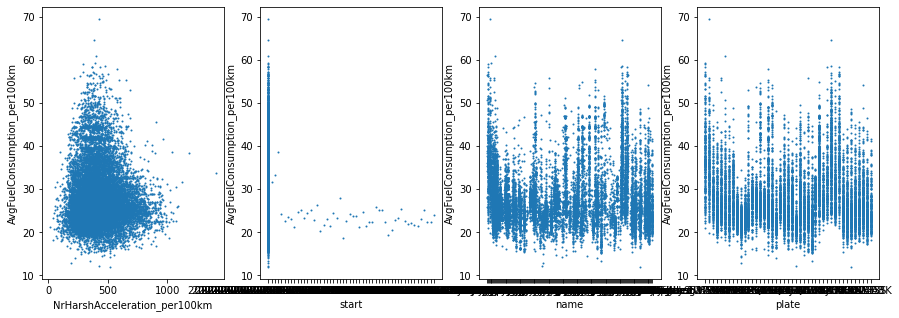

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt


ZF_DATA_timestamped = pd.read_csv("Data/Export_data_ZF_tsv2.csv")
ZF_DATA = ZF_DATA_timestamped
driverids = list(set(ZF_DATA_timestamped['DriverID']))
vehicleids = list(set(ZF_DATA_timestamped['VehicleID']))

ZF_KEYS = namedtuple("ZF_KEYS", ZF_DATA_timestamped.keys())
KEYS = ZF_KEYS( **{k:k for k in ZF_DATA_timestamped.keys()} )

y_key = "AvgFuelConsumption_per100km"

for i, k in enumerate(ZF_DATA_timestamped.keys()):
    if i%4 == 0:
        if i > 0:
            plt.show()
        fig, axs = plt.subplots(1,4, figsize=(15,5))
    
    ZF_DATA_timestamped.plot.scatter(x=k,y=y_key, ax=axs[i%4], s=1)    

# Correlation coefficients between attributes after removing categorical data

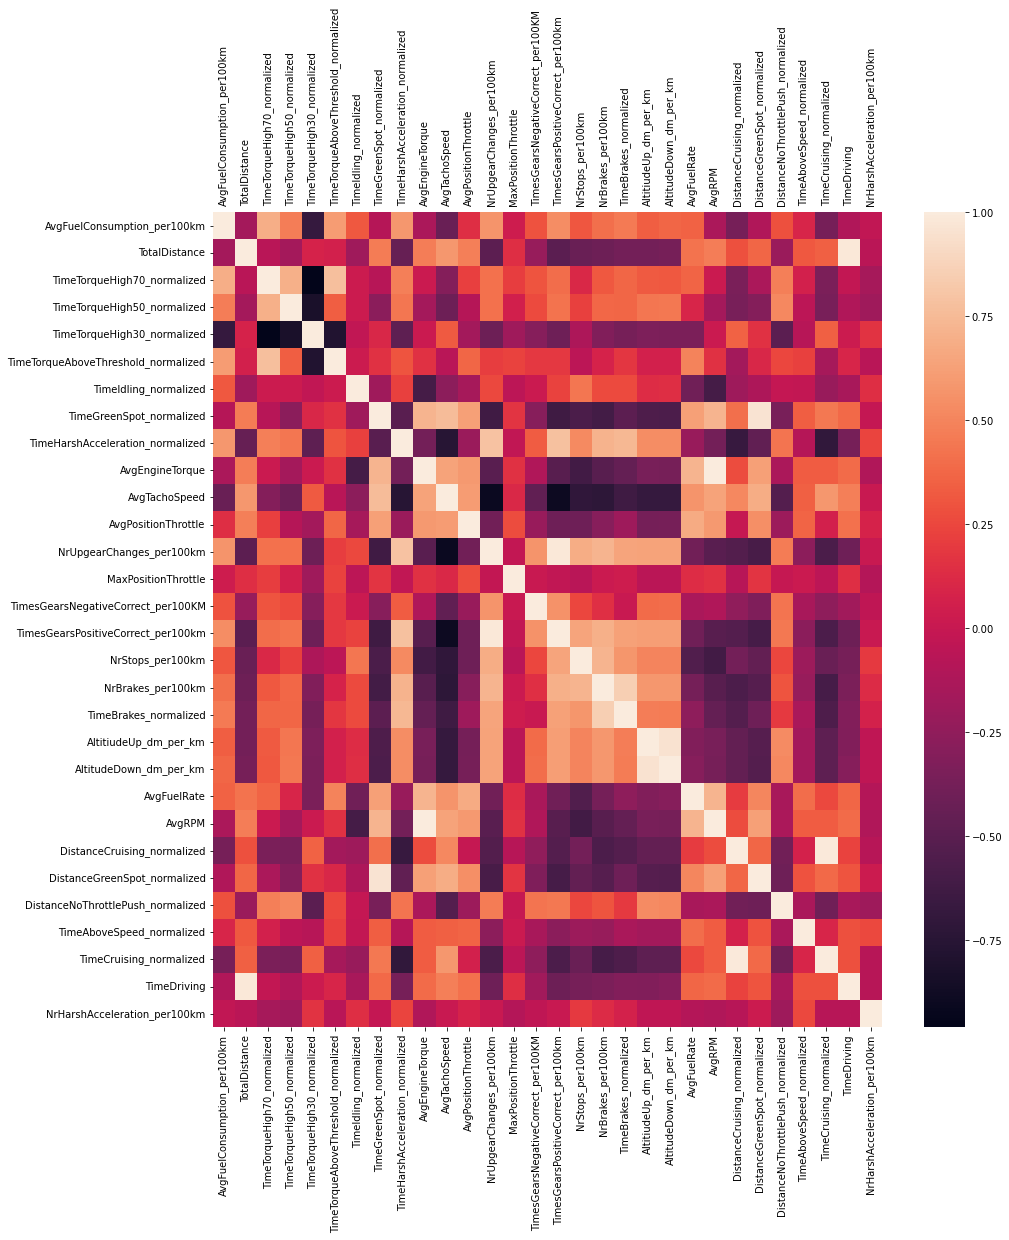

In [2]:
clean_df = ZF_DATA_timestamped.copy()

categorical_columns = [
    'DriverID', 'VehicleID', 'VehicleSegmentID', 'TripID','Driver_Cluster','Trip_Cluster',
    'TotalFuel', 'TimeGear13_norm','TimeGear15_norm','TimeGear16_norm',
    'start', 'name', 'plate'] # 'TotalDistance', 'TimeDriving'

time_gear = [k for k in list(KEYS) if "TimeGear" in k]

clean_df = clean_df.drop(columns=categorical_columns + time_gear)

fig, ax = plt.subplots(1,1, figsize=(15,15))
plt.tick_params(labeltop=True, labelbottom=True)
_ = sns.heatmap(clean_df.corr(), ax=ax)

In [3]:
(clean_df.corr()['AvgFuelConsumption_per100km']**2).argsort()[:40].index[2:]

Index(['TimeTorqueHigh70_normalized', 'TimeTorqueHigh50_normalized',
       'TimeTorqueHigh30_normalized', 'TimeTorqueAboveThreshold_normalized',
       'TimeIdling_normalized', 'TimeGreenSpot_normalized',
       'TimeHarshAcceleration_normalized', 'AvgEngineTorque', 'AvgTachoSpeed',
       'AvgPositionThrottle', 'NrUpgearChanges_per100km',
       'MaxPositionThrottle', 'TimesGearsNegativeCorrect_per100KM',
       'TimesGearsPositiveCorrect_per100km', 'NrStops_per100km',
       'NrBrakes_per100km', 'TimeBrakes_normalized', 'AltitiudeUp_dm_per_km',
       'AltitudeDown_dm_per_km', 'AvgFuelRate', 'AvgRPM',
       'DistanceCruising_normalized', 'DistanceGreenSpot_normalized',
       'DistanceNoThrottlePush_normalized', 'TimeAboveSpeed_normalized',
       'TimeCruising_normalized', 'TimeDriving',
       'NrHarshAcceleration_per100km'],
      dtype='object')

# PCA between mean vehicle attributes
## First 4 principal components capture 95% of the variance

[0.52944234 0.84492236 0.92177918 0.9534044 ]


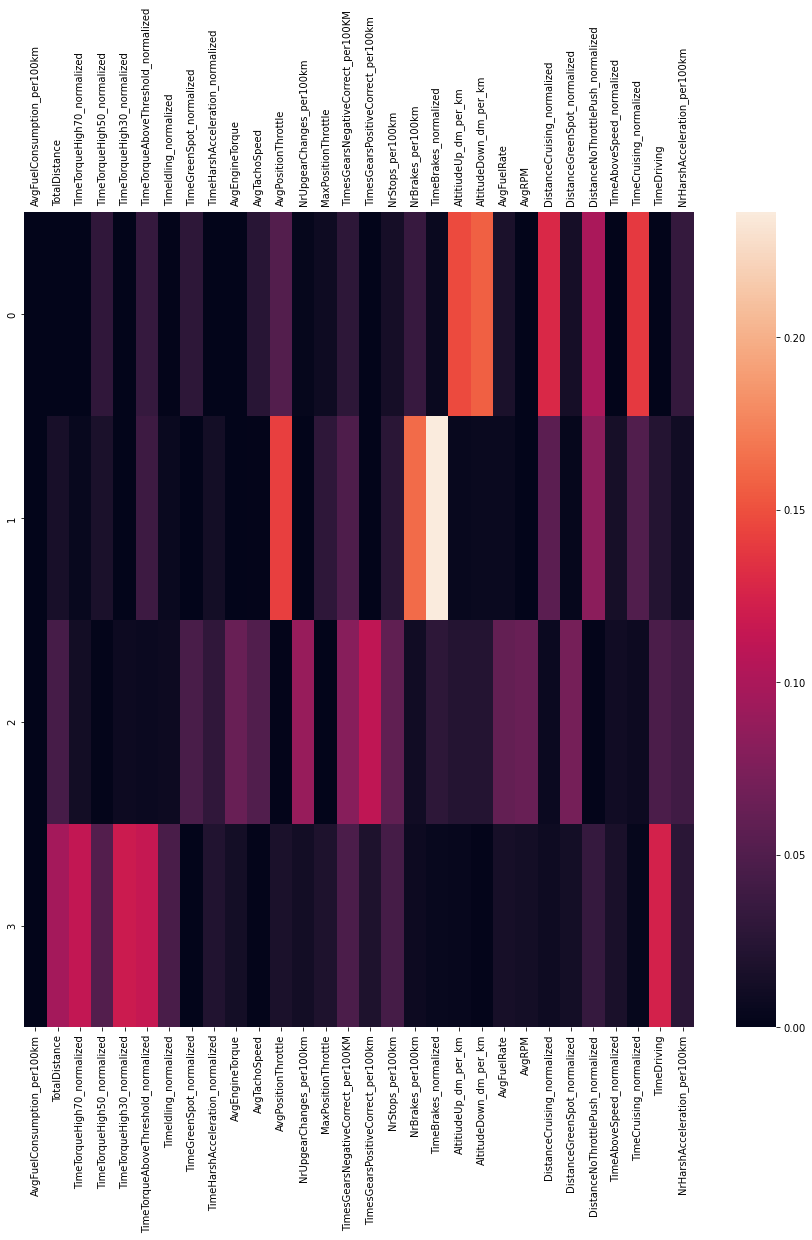

In [4]:
from sklearn.decomposition import PCA
vehicle_df = clean_df
vehicle_df[KEYS.VehicleID] = ZF_DATA_timestamped[KEYS.VehicleID]
vehicle_df[KEYS.TotalDistance] = vehicle_df[KEYS.TotalDistance]
vehicle_df = vehicle_df.groupby(KEYS.VehicleID).mean()


pca = PCA(n_components=len(vehicle_df.keys()))
normalized_df=(vehicle_df-vehicle_df.mean())/vehicle_df.std()

# Divide each attribute by AvgFuelConsumption_per100km to get a score with respect to AvgFuelConsumption_per100km
vehicledf_per_avgfuelper100 = pd.DataFrame(
    np.array(normalized_df)/np.array(normalized_df['AvgFuelConsumption_per100km'])[:,None],
    columns=normalized_df.keys())
pca.fit(vehicledf_per_avgfuelper100)


fig, ax = plt.subplots(1,1, figsize=(15,15))
plt.tick_params(labeltop=True, labelbottom=True)
sns.heatmap(pd.DataFrame(pca.components_[:4]**2, columns=vehicledf_per_avgfuelper100.keys()))

print(np.cumsum( pca.explained_variance_ / pca.explained_variance_.sum())[:4])
# print(pca.explained_variance_ / pca.explained_variance_.sum())

In [5]:
def get_best_avgs(attributes, group_by, normalize=True, weights = None):
    if normalize:
        normalized_attributes = (ZF_DATA[attributes] - ZF_DATA[attributes].mean()) / ZF_DATA[attributes].std()
    else:
        normalized_attributes = ZF_DATA[attributes].copy()
        
    for i, k in enumerate(attributes):
#         if not use_min_:
#             normalized_attributes[k] = normalized_attributes[k] * -1
        if weights is not None:
            normalized_attributes[k] = normalized_attributes[k] * weights[i]
            
    normalized_attributes['ACC'] = normalized_attributes.sum(axis=1)
    normalized_attributes[group_by] = ZF_DATA[group_by]
    
    avg_values = normalized_attributes.groupby(group_by)['ACC'].mean()
    
    return avg_values.keys()[avg_values.argmax() ]
    

def get_vehicle(selection_criteria, weights=None):
    best_id = get_best_avgs(selection_criteria, group_by=KEYS.VehicleID, weights=weights)
    return best_id # ZF_DATA[ZF_DATA[KEYS.VehicleID] == best_id][selection_criteria].mean()

def get_driver(selection_criteria, weights=None):
    best_id = get_best_avgs(selection_criteria, group_by=KEYS.DriverID, weights=weights)
    return best_id

In [6]:
drop_cols = categorical_columns + time_gear + ['TimeDriving', 'TotalDistance']
trunc_data = ZF_DATA_timestamped.drop(columns=drop_cols)
trunc_data_normalized = (trunc_data - trunc_data.mean()) / trunc_data.std()

# First 11 PC explain 95% of the variance for the user data

In [8]:
user_trunc_data_normalized = trunc_data_normalized.copy()
user_trunc_data_normalized[KEYS.DriverID] = ZF_DATA_timestamped[KEYS.DriverID]
user_trunc_data_normalized_aggregated = user_trunc_data_normalized.groupby(KEYS.DriverID).mean()

pca_user = PCA(n_components=len(user_trunc_data_normalized_aggregated.keys()))
pca_user.fit( user_trunc_data_normalized_aggregated )
print( np.cumsum( pca_user.explained_variance_ / pca_user.explained_variance_.sum() ) )

pca_user = PCA(n_components=11)
pca_user.fit( user_trunc_data_normalized_aggregated )

[0.47575607 0.60514088 0.70482753 0.76300179 0.80879952 0.84401106
 0.87543949 0.90160039 0.92204776 0.93816042 0.95154049 0.96238732
 0.97070845 0.97765192 0.9830413  0.98766169 0.99118919 0.9938907
 0.99608773 0.99767136 0.99890889 0.99931525 0.99955581 0.99973747
 0.99990913 1.         1.         1.        ]


PCA(n_components=11)

# First 10 PC explain 95% of the variance for the vehicle data

In [10]:
vehicle_trunc_data_normalized = trunc_data_normalized.copy()
vehicle_trunc_data_normalized[KEYS.VehicleID] = ZF_DATA_timestamped[KEYS.VehicleID]

vehicle_trunc_data_normalized_aggregated = vehicle_trunc_data_normalized.groupby(KEYS.VehicleID).mean()

pca_vehicle = PCA(n_components=len(vehicle_trunc_data_normalized_aggregated.keys()))
pca_vehicle.fit( vehicle_trunc_data_normalized_aggregated )
print( np.cumsum( pca_vehicle.explained_variance_ / pca_vehicle.explained_variance_.sum() ) )

pca_vehicle = PCA(n_components=10)
pca_vehicle.fit( vehicle_trunc_data_normalized_aggregated )

[0.38917995 0.59746203 0.69249376 0.77427434 0.82832823 0.86701725
 0.90163289 0.9247256  0.94448075 0.96015065 0.97418644 0.98239286
 0.98768712 0.99188571 0.99433152 0.9962503  0.99759735 0.99840045
 0.99894123 0.99924977 0.99953496 0.99975263 0.99987879 0.99994947
 0.9999837  1.         1.         1.        ]


PCA(n_components=10)

In [11]:
from scipy.stats.mstats import pearsonr

def get_feature(key, id_, df):
    return df[df[key] == id_].mean()

def get_user_feat(user_id):
    return pca_user.transform(
        user_trunc_data_normalized_aggregated[user_trunc_data_normalized_aggregated.index == user_id])

def get_vehicle_drivers(vehicle_id):
    return list(set(select_vehicle(vehicle_id)['DriverID']))

def get_expected_avgfuel100(selected_driver_id, vehicle_id):
    driver_ids = get_vehicle_drivers(vehicle_id)
    
    driver_feat = np.concatenate( [ get_user_feat(driver_id) for driver_id in driver_ids ] )
    selected_driver_feat = get_user_feat(selected_driver_id)
    
    similarity = ([pearsonr(selected_driver_feat[0], vehicle_driver_feat)[0] for vehicle_driver_feat in driver_feat])
    similarity_sum = sum(similarity)
    
    expected_avgfuel100 = 0
    for driver_id, sim in zip(driver_ids, similarity):
        mask = (ZF_DATA_timestamped[KEYS.DriverID] == driver_id) & (ZF_DATA_timestamped[KEYS.VehicleID] == vehicle_id)
        expected_avgfuel100 += sim * ZF_DATA_timestamped['AvgFuelConsumption_per100km'][mask].mean()
    
    return expected_avgfuel100 / similarity_sum


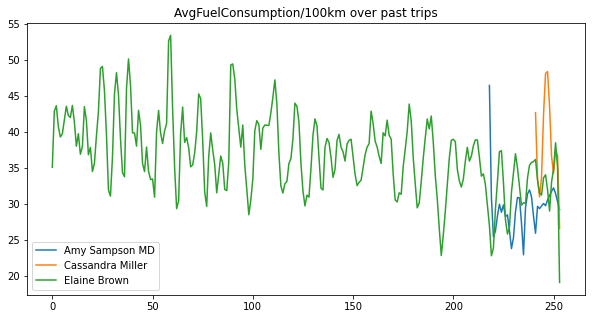

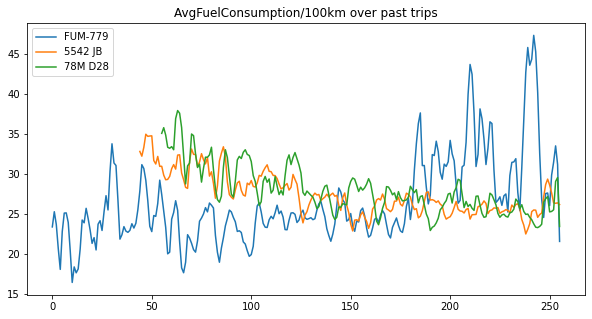

In [13]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def get_xy(y, start=0, end=-1, smoothen=True):
    y = np.array(y)
    x = np.arange(start, start + len(y) if end < 0 else end)
    return x, savgol_filter(y, 7, 3) if smoothen else y

def select_id_rows(id_, key_):
    return ZF_DATA_timestamped[ZF_DATA_timestamped[key_] == id_]

def select_driver(driverid):
    return select_id_rows(driverid, KEYS.DriverID)

def select_vehicle(vehicleid):
    return select_id_rows(vehicleid, KEYS.VehicleID)

def plot_over_past_trips(selected_ids, key_, name_key=None):
    plt.figure(figsize=(10,5))
    
    driver_avgfuel = []
    max_length = max([len(select_id_rows(s, key_)) for s in selected_ids])

    for id_ in selected_ids:
        zf_data = select_id_rows(id_, key_)
        plt.plot(
            *get_xy(
                zf_data['AvgFuelConsumption_per100km'],
                start=max_length - len(zf_data), end=max_length),
            alpha=1, label=zf_data[name_key if name_key else key_].iloc[0])

    plt.legend()
    plt.title("AvgFuelConsumption/100km over past trips")
    
plot_over_past_trips(['Driver4','Driver5','Driver6'], KEYS.DriverID, 'name')
plt.show()
plot_over_past_trips(['Vehicle7','Vehicle8','Vehicle9'], KEYS.VehicleID, 'plate')


In [16]:
def show(**kwargs): # traveled_dist=100., fuel_price=2.1, 
    weights = { k:v for k,v in list(kwargs.items())[:-2] }
    traveled_dist=kwargs['traveled_dist']
    fuel_price=kwargs['fuel_price']
    ljustdist = 45
    crit = [k for k,w in weights.items() if w != 0.]
    weights = [w for w in weights.values() if w != 0.]
    
#     crit = [KEYS.AvgFuelConsumption_per100km, KEYS.TotalDistance]
    best_vehicle = get_vehicle(crit, weights=weights)
    best_driver = get_driver(crit, weights = weights)
    
    print('Best vehicle: ', best_vehicle)
    mean_crit = ZF_DATA[ZF_DATA[KEYS.VehicleID] == best_vehicle][crit].mean()
    print("\n".join([ f"{k}:".ljust(ljustdist)+f"{mean_crit_:.3f}" for k,mean_crit_ in zip(crit, mean_crit) ]))
    vehicle_avg_fuel = select_vehicle(best_vehicle)[KEYS.AvgFuelConsumption_per100km].mean()
    print('Vehicle avg fuel/100km:'.ljust(ljustdist), f"{vehicle_avg_fuel:.3f}")
    print()

    print("-----------------")
    print('Best driver: ', best_driver)
    mean_crit = ZF_DATA[ZF_DATA[KEYS.DriverID] == best_driver][crit].mean()
    print("\n".join([ f"{k}:".ljust(ljustdist)+f"{mean_crit_:.3f}" for k,mean_crit_ in zip(crit, mean_crit) ]))
    print('Driver\'s avg fuel/100km:'.ljust(ljustdist), f"{select_driver(best_driver)[KEYS.AvgFuelConsumption_per100km].mean():.3f}")
    
    expected_avgfuel100 = get_expected_avgfuel100(best_driver, best_vehicle)
    
    print("\n---------------")
    print('Expected avg fuel/100km: '.ljust(ljustdist), f"{expected_avgfuel100:.2f}")
    print('Vehicle avg fuel/100km: '.ljust(ljustdist), f"{vehicle_avg_fuel:.2f}")
    
    print('Expected Gain/100km: '.ljust(ljustdist), f"{2.1 * (vehicle_avg_fuel - expected_avgfuel100):.2f} CHF")
    print('Expected Total Gain: '.ljust(ljustdist), 
          f"{2.1 * (vehicle_avg_fuel - expected_avgfuel100) * traveled_dist:.2f} CHF")
    

from ipywidgets import interact
import ipywidgets as widgets

corr_keys = (clean_df.corr()['AvgFuelConsumption_per100km']**2).argsort()[:40].index[2:]

_=interact( show, **{k: widgets.FloatSlider(
    value=0.,min=-5,max=5,
    layout = widgets.Layout(overflow="flex", width="500px"), description=k.rjust(34,"_"),
    style={'description_width': 'initial'}
) for k in ['AvgFuelConsumption_per100km'] + list(corr_keys)},
          traveled_dist=widgets.BoundedFloatText(
    value=100,
    min=0,
    max=5000.,
    step=0.01,
    description='dist (km)',
    disabled=False
),
          fuel_price=widgets.BoundedFloatText(
              value=2.1, min=0, max=5000.,step=0.01,description='Fuel (CHF)',disabled=False)
)


interactive(children=(FloatSlider(value=0.0, description='_______AvgFuelConsumption_per100km', layout=Layout(o…

### Example output
```
Best vehicle:  Vehicle14
AvgFuelConsumption_per100km:                  22.206
Vehicle avg fuel/100km:                       22.206

-----------------
Best driver:  Driver96
AvgFuelConsumption_per100km:                  19.194
Driver's avg fuel/100km:                      19.194

---------------
Expected avg fuel/100km:                      21.70
Vehicle avg fuel/100km:                       22.21
Expected Gain/100km:                          1.06 CHF
Expected Total Gain:                          1057.36 CHF
```